# Simulation with SPAM errors

## Introduction
On the tutorial `Simulating sequences with errors and noises`, we introduced SPAM errors and here we will go in deeper details. If you didn't missed that tutorial, please go back there before going through this one.

The SPAM errors or State Preparation And Measurement errors encapsulates errors, as its name indicates, are some errors that occurs during state preparation and measurement. There are three types of such errors:
* One (with probability $\eta$) is related to bad initial state preparation of the all-ground state $\Ket{g}^{\otimes n}$
* The two others, (with probabilities $\epsilon, \epsilon '$) are linked to detection errors. During the imaging process, excited Rydberg atoms in $\Ket{r}$ might decay to the state $\Ket{g}$, allowing them to be trapped in the tweezers : those are the false negatives modeled by $\epsilon'$. On the contrary, some atoms in $\Ket{g}$ might get excited due to various causes (collisions...) and tweezer recapture might fail, inferring them incorrectly as atoms in $\Ket{r}$ : those are the false positives modeled by $\epsilon$.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import ConstantWaveform, RampWaveform

## Single atom noisy simulations

### Sequence preparation

Prepare a single atom:

In [34]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

Act on this atom with a Constant Pulse, such that it oscillates towards the excited Rydberg state and back to the original state (Rabi oscillations):

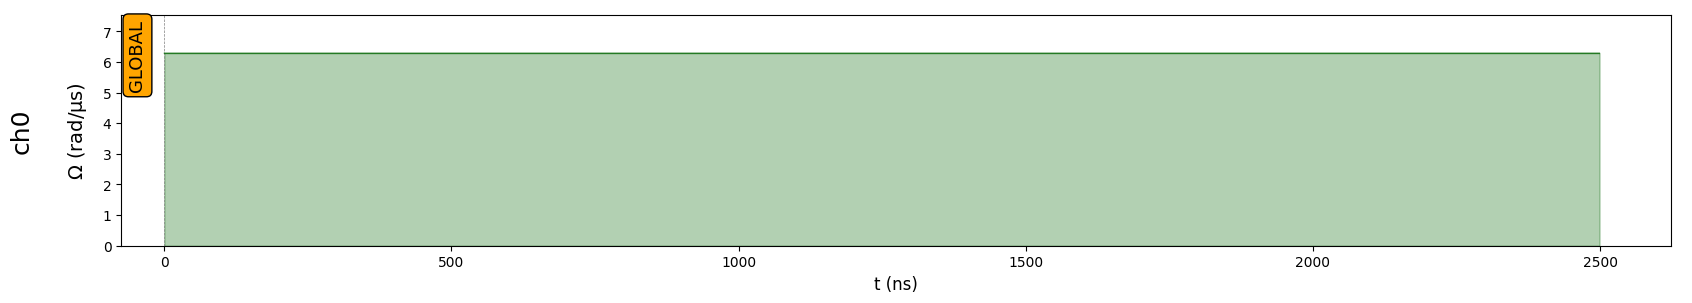

In [35]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "ch0")
seq.draw()

We now create the simulation object

In [36]:
sim = Simulation(seq, sampling_rate=0.05)
obs = qutip.basis(2, 0).proj()
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)

We haven't added yet the SPAM error

In [37]:
sim.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


## SPAM effects

Compare both clean and noisy simulations for the default SPAM parameters (taken from [De Léséleuc, et al., 2018](https://arxiv.org/abs/1802.10424))

In [20]:
sim.set_config(config_spam)
sim.evaluation_times = 0.4
res_spam = sim.run()
sim.show_config()

Options:
----------
Number of runs:        30
Samples per run:       5
Noise types:           SPAM
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}


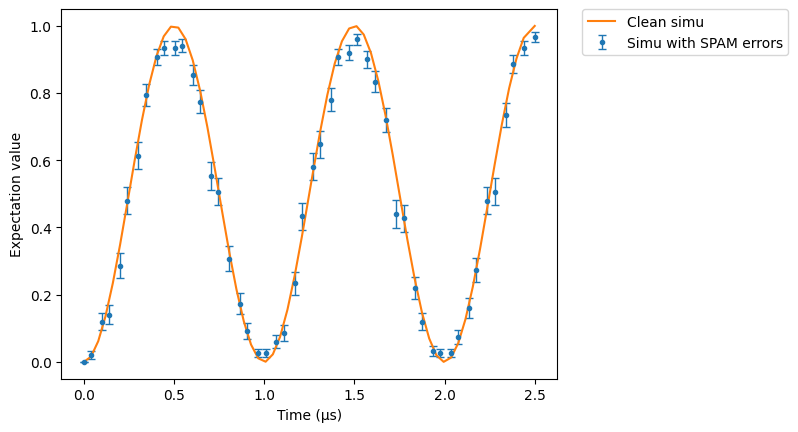

In [26]:
res_spam.plot(obs, label="Simu with SPAM errors")
sim.reset_config()
sim.eval_times = "Full"
res_clean = sim.run()
res_clean.plot(obs, label="Clean simu")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

We will now modify the *SPAM* dictionary, as below, allowing for more ($40$%) badly prepared atoms.

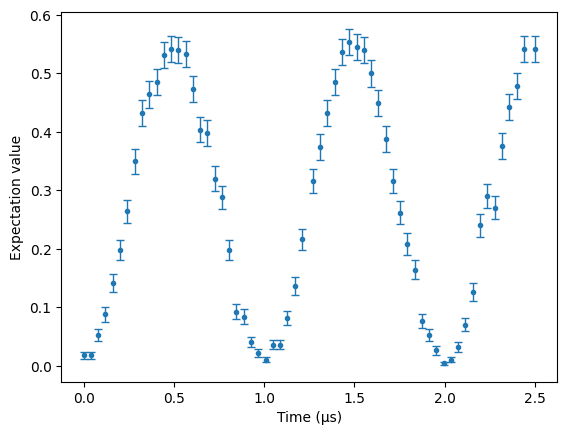

In [27]:
config_spam_mod = SimConfig(noise=("SPAM"), eta=0.4, runs=100)
sim.set_config(config_spam_mod)
sim.evaluation_times = 0.5
res_large_eta = sim.run()
res_large_eta.plot(obs)

We can see here that the population doesn't go well above $0.6 = 1 - \eta$, which is to be expected : badly prepared atoms don't reach state $\Ket{r}$. We can expect this limit of $0.6$ in the Rydberg population to be more and more respected as the number of runs grows.

## Changing $\eta$

Let us first initialize all spam error values to $0$. Then, we do a sweep over the parameter $\eta$, probability of badly prepared states, to notice its effects.

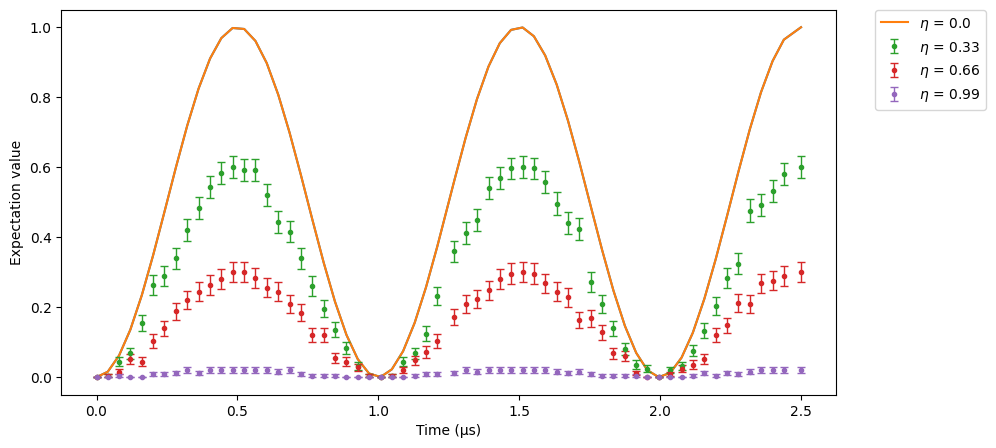

In [29]:
plt.figure(figsize=(10, 5))
res_clean.plot(obs)
for eta in np.linspace(0, 0.99, 4):
    config_spam_eta = SimConfig(
        noise="SPAM", eta=eta, runs=50, epsilon=0, epsilon_prime=0
    )
    sim.set_config(config_spam_eta)
    sim.run().plot(obs, label=rf"$\eta$ = {eta}")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

As $\eta$ grows, more qubits are not well-prepared (i.e, pumped into a state different from $\Ket{g}$) and we stop seeing occupations at all. You may increase the number of runs to smooth the curves.

### Changing $\epsilon$

Let's now run a sweep over $\epsilon$.

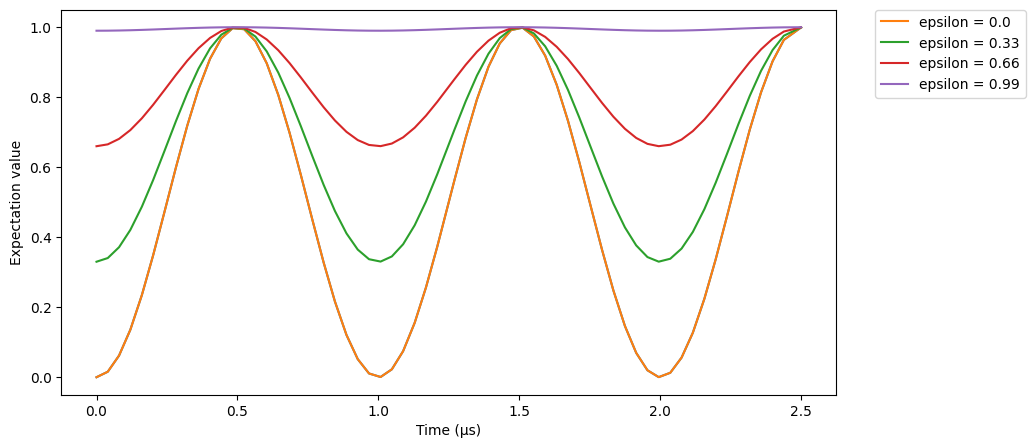

In [30]:
plt.figure(figsize=(10, 5))
res_clean.plot(obs)
for eps in np.linspace(0, 0.99, 4):
    config_spam_eps = SimConfig(
        noise="SPAM", eta=0, runs=50, epsilon=eps, epsilon_prime=0
    )
    sim.set_config(config_spam_eps)
    sim.run().plot(obs, label=f"epsilon = {eps}")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

As more false positives appear, it looks like the system is never captured, so always in a Rydberg state. Note that when $\eta=0$, the object we obtain is a `CoherentResults` rather than a `NoisyResults`, since in this case, the randomness comes from measurements and the simulation is entirely deterministic. This results in smooth curves rather than scattered dots.

### Changing $\epsilon'$

Finally, we run a sweep over $\epsilon'$.

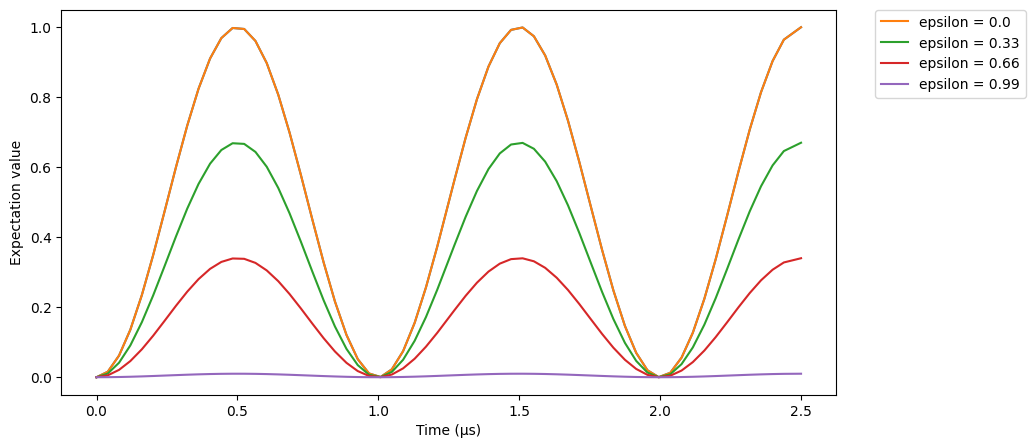

In [31]:
plt.figure(figsize=(10, 5))
res_clean.plot(obs)
for eps_p in np.linspace(0, 0.99, 4):
    config_spam_eps_p = SimConfig(
        noise="SPAM", eta=0, runs=50, epsilon=0, epsilon_prime=eps_p
    )
    sim.set_config(config_spam_eps_p)
    sim.run().plot(obs, label=f"epsilon = {eps_p}")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

As there are more false negatives, all atoms seem to be recaptured, until no Rydberg occupation is detected.